# **Ciencia de Datos para Sensores Inteligentes**
### **Práctica 1: Procesamiento de audio.**

Ian Svén Castellanos Soto.

El objetivo de esta práctica es desarrollar un clasificador de actividades basado en análisis de audio capturado en entornos domésticos. Se utilizarán técnicas de procesamiento de audio para remover ruido de fondo y normalizar el volumen de las muestras de audio, así como extracción de características para aplicarlas a modelos de aprendizaje automático que permitirán identificar las diferentes actividades representadas en el conjunto de datos.

Dicho conjunto de datos fue creado de manera colaborativa por los estudiantes del curso para identificar seis actividades cotidianas. Cada uno de los diez estudiantes grabó tres archivos `.wav` de diez segundos por clase, por lo que el conjunto final tiene 180 elementos. 

Las clases son las siguientes (etiqueta y descripción):
- `Bano`: bajarle al inodoro.
- `Cocina`: lavar platos.
- `Pasos`: pasos al caminar (en varios lugares).
- `Sala`: una conversación.
- `Oficina`: música de fondo.
- `Nula`: sonidos que no entran en ninguna de las categorías anteriores.

Los archivos fueron nombrados como ID_CLASE_MUESTRA.wav, donde ID son las iniciales del estudiante, CLASE indica la clase que representa el archivo y MUESTRA indica el número de muestra (01 a 03).

In [86]:
# Sistema
import os

# Procesamiento de audio
import numpy as np
import librosa
import pandas as pd
import noisereduce as nr
import soundfile as sf
from matplotlib import pyplot as plt
import seaborn as sns

# Aprendizaje de máquina
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

In [31]:
raw_path = "data/raw_files"
train_path = "data/train"
raw_test_path = "data/raw_files/test_raw"
test_path = "data/test"

## Procesamiento de los datos

Primero se removió el sonido de fondo de todos los audios del conjunto de prueba, seguido de una normalización de volumen. Esto con el fin de mantener un volumen consistente en los datos y así evitar sesgos de cualquier tipo.

Definición de funciones para limpiar audio de todos los archivos del conjunto de datos:

In [32]:
def clean_audio(file_path, sr=22050):
    audio, sr = librosa.load(file_path, sr=sr)

    noise = audio[0:sr//2] # Se tomará al primer medio segundo como muestra de ruido
    audio_denoised = nr.reduce_noise(y=audio, sr=sr, y_noise=noise)
    audio_normalized = librosa.util.normalize(audio_denoised)

    return audio_normalized, sr

In [33]:
def batch_clean(src, dst):
    for fname in os.listdir(src):
        if not fname.lower().endswith(".wav"):
            continue
        in_path = os.path.join(src, fname)
        out_path = os.path.join(dst, fname)
        audio, sr = clean_audio(in_path)
        sf.write(out_path, audio, sr)

In [29]:
batch_clean(raw_path, train_path)
batch_clean(raw_test_path, test_path)

## Extracción de características

In [40]:
dataset_df = pd.DataFrame(columns=["name","path","id","label","sample","type"])

def read_wav(folder, file_type):
    rows = []
    for fname in os.listdir(folder):
        if not fname.lower().endswith(".wav"):
            continue
        name, _ = os.path.splitext(fname)
        parts = name.split("_")
        if len(parts) != 3:
            continue
        id_, label, sample = parts
        rows.append({
            "name": fname.lower(),
            "path": os.path.join(folder, fname),
            "id": id_.lower(),
            "label": label.lower(),
            "sample": sample,
            "type": file_type
        })
    return rows

dataset_df = pd.concat([dataset_df,pd.DataFrame(read_wav(raw_path, "train")),pd.DataFrame(read_wav(test_path, "test"))], ignore_index=True)

In [41]:
dataset_df

,name,path,id,label,sample,type
0,disc_bano_01.wav,data/raw_files/DISC_BANO_01.wav,disc,bano,01,train
1,disc_bano_02.wav,data/raw_files/DISC_BANO_02.wav,disc,bano,02,train
2,disc_bano_03.wav,data/raw_files/DISC_BANO_03.wav,disc,bano,03,train
3,disc_cocina_01.wav,data/raw_files/DISC_COCINA_01.wav,disc,cocina,01,train
4,disc_cocina_02.wav,data/raw_files/DISC_COCINA_02.wav,disc,cocina,02,train
...,...,...,...,...,...,...
193,jmrr_pasos_02.wav,data/test/JMRR_pasos_02.wav,jmrr,pasos,02,test
194,jmrr_pasos_03.wav,data/test/JMRR_pasos_03.wav,jmrr,pasos,03,test
195,jmrr_sala_01.wav,data/test/JMRR_sala_01.wav,jmrr,sala,01,test
196,jmrr_sala_02.wav,data/test/JMRR_sala_02.wav,jmrr,sala,02,test


In [42]:
def extract_features(file_path, sr=22050, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=sr)

    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc).mean(axis=1)

    features = {}

    for i, coefficient in enumerate(mfccs):
        features[f"mfcc_{i+1}"] = coefficient

    features["zcr"] = np.mean(librosa.feature.zero_crossing_rate(y=audio))
    features["rms"] = np.mean(librosa.feature.rms(y=audio))

    return features

In [63]:
rows = []

for file in os.listdir(train_path):
    path = os.path.join(train_path, file)

    parts = file.replace(".wav", "").split("_")
    file_id = parts[0]
    label = parts[1]

    features = extract_features(path)

    row = {
        "name": file,
        "path": path,
        "label": label.lower(),
        "type": "train",
        **features
    }

    rows.append(row)

for file in os.listdir(test_path):
    path = os.path.join(test_path, file)

    parts = file.replace(".wav", "").split("_")
    file_id = parts[0]
    label = parts[1]

    features = extract_features(path)

    row = {
        "name": file,
        "path": path,
        "label": label.lower(),
        "type": "test",
        **features
    }

    rows.append(row)

dataset_df = pd.DataFrame(rows)
features_path = "data/dataset_features.csv"
dataset_df.to_csv(features_path, index=False)

In [64]:
dataset_df

,name,path,label,type,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,zcr,rms
0,DISC_BANO_01.wav,data/train/DISC_BANO_01.wav,bano,train,-451.450226,31.853138,-5.122707,1.194066,8.400017,-0.624716,1.363284,9.449452,1.810640,-0.230194,-1.410067,1.005153,-3.272155,0.210379,0.028968
1,DISC_BANO_02.wav,data/train/DISC_BANO_02.wav,bano,train,-402.268280,24.979153,4.193405,8.459323,-0.712893,-1.525791,-7.739481,-8.132113,-6.525773,-0.572705,-0.448457,3.208452,-3.238141,0.215773,0.031932
2,DISC_BANO_03.wav,data/train/DISC_BANO_03.wav,bano,train,-474.485962,35.087490,8.589269,8.714620,-1.870391,-4.413589,-2.668145,-1.274885,-1.888020,-0.044704,-0.410282,-1.819422,-1.907768,0.182699,0.020453
3,DISC_COCINA_01.wav,data/train/DISC_COCINA_01.wav,cocina,train,-480.800110,47.499622,-0.354472,12.828190,-2.530039,2.880156,2.095027,2.079938,3.429204,0.831632,-2.691416,0.890970,-2.930792,0.171490,0.020071
4,DISC_COCINA_02.wav,data/train/DISC_COCINA_02.wav,cocina,train,-473.388519,28.094309,-0.086108,-0.024187,-4.365237,-0.642791,-3.239082,-0.456897,-3.321329,-0.931952,-1.443277,1.746281,-0.194519,0.188255,0.020651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,JMRR_pasos_02.wav,data/test/JMRR_pasos_02.wav,pasos,test,-525.924072,49.394802,5.107052,17.228098,3.486950,2.889127,-2.141874,2.882770,-2.526718,-0.708519,4.344784,2.135765,3.194959,0.097845,0.020155
194,JMRR_pasos_03.wav,data/test/JMRR_pasos_03.wav,pasos,test,-540.528137,44.177570,2.707105,14.935709,2.269398,7.290967,-2.625449,1.211774,-1.919709,1.205135,5.058015,1.654420,1.729111,0.058094,0.017068
195,JMRR_sala_01.wav,data/test/JMRR_sala_01.wav,sala,test,-466.456146,55.844982,8.249162,23.379004,10.742558,12.402538,-2.088456,-1.029083,9.341481,2.177981,-3.870990,-2.554315,0.915231,0.093860,0.036071
196,JMRR_sala_02.wav,data/test/JMRR_sala_02.wav,sala,test,-389.586548,96.228065,35.173145,28.967560,6.106502,5.381415,-11.345426,-4.498087,-23.452318,-17.081587,-11.881171,-12.603093,-3.438339,0.104659,0.071056


## Construcción y evaluación de modelos

Se preparan los conjuntos de entrenamiento y de prueba.

In [83]:
features_df = pd.read_csv(features_path)

features_train_df = features_df[features_df['type'] == 'train']
features_test_df = features_df[features_df['type'] == 'test']

X_train = features_train_df.drop(columns=['name', 'path', 'label', 'type'])
y_train = features_train_df['label']

X_test = features_test_df.drop(columns=['name', 'path', 'label', 'type'])
y_test = features_test_df['label']

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
print(f"Clases: {label_encoder.classes_}")

Clases: ['bano' 'cocina' 'nula' 'oficina' 'pasos' 'sala']


Se utilizarán los modelos _Random Forest_, k-NN y SVM.

In [ ]:
models = {
    "Random Forest": Pipeline(steps=[('scaler', StandardScaler()),('classifier', RandomForestClassifier(n_estimators=100, random_state=150800))]),
    "SVM": Pipeline(steps=[('scaler', StandardScaler()),('classifier', SVC(kernel='rbf', probability=True, random_state=150800))]),
    "k-NN": Pipeline(steps=[('scaler', StandardScaler()),('classifier', KNeighborsClassifier(n_neighbors=5))])
}


Random Forest:
F1-Score (Validación cruzada): 0.5920
F1-Score: 0.4722
Precisión: 0.5000

Resultados:
[{'Modelo': 'Random Forest', 'F1-Score (Validación cruzada)': np.float64(0.592024087024087), 'F1-Score': 0.47222222222222215, 'Precisión': 0.5}]


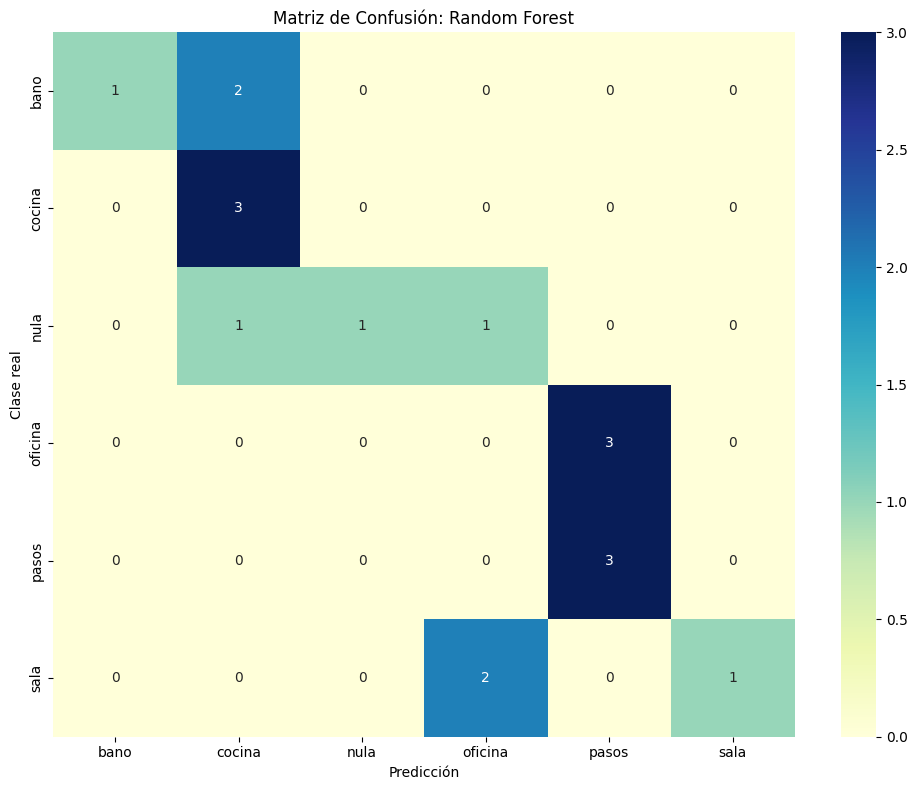


SVM:
F1-Score (Validación cruzada): 0.6271
F1-Score: 0.2778
Precisión: 0.3889

Resultados:
[{'Modelo': 'Random Forest', 'F1-Score (Validación cruzada)': np.float64(0.592024087024087), 'F1-Score': 0.47222222222222215, 'Precisión': 0.5}, {'Modelo': 'SVM', 'F1-Score (Validación cruzada)': np.float64(0.6271204503557446), 'F1-Score': 0.27777777777777773, 'Precisión': 0.3888888888888889}]


/home/ian/Documents/Grad school/Ciencia de Datos para Sensores Inteligentes/Práctica 1/.venv/lib64/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ian/Documents/Grad school/Ciencia de Datos para Sensores Inteligentes/Práctica 1/.venv/lib64/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ian/Documents/Grad school/Ciencia de Datos para Sensores Inteligentes/Práctica 1/.venv/lib64/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: P

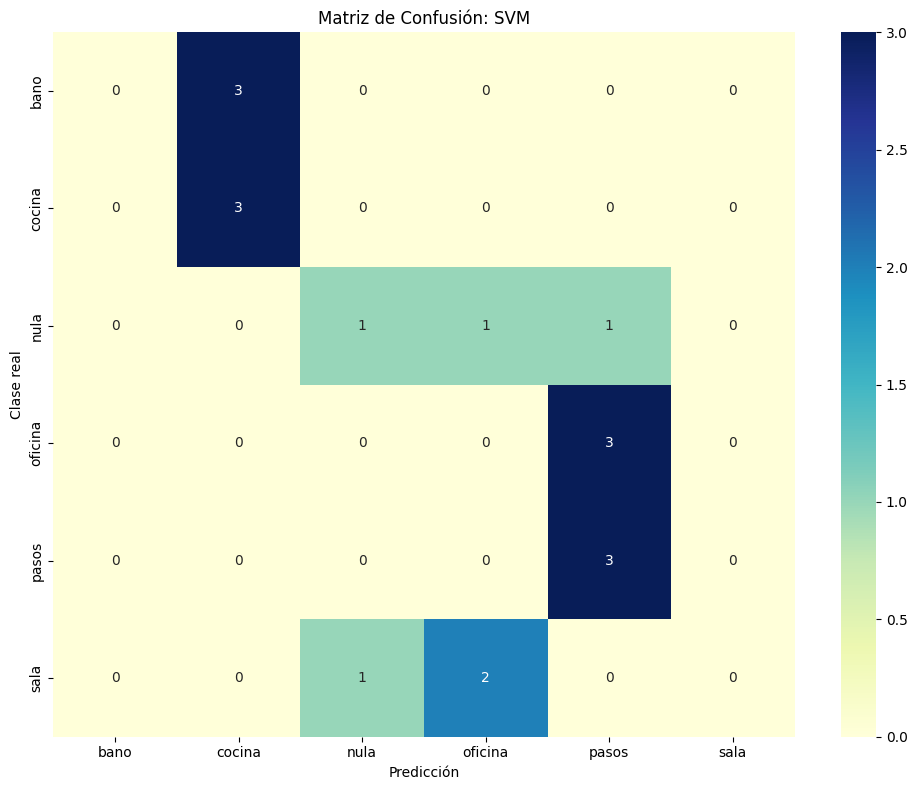


k-NN:
F1-Score (Validación cruzada): 0.4474
F1-Score: 0.3519
Precisión: 0.4444

Resultados:
[{'Modelo': 'Random Forest', 'F1-Score (Validación cruzada)': np.float64(0.592024087024087), 'F1-Score': 0.47222222222222215, 'Precisión': 0.5}, {'Modelo': 'SVM', 'F1-Score (Validación cruzada)': np.float64(0.6271204503557446), 'F1-Score': 0.27777777777777773, 'Precisión': 0.3888888888888889}, {'Modelo': 'k-NN', 'F1-Score (Validación cruzada)': np.float64(0.4473935215111685), 'F1-Score': 0.35192307692307695, 'Precisión': 0.4444444444444444}]


/home/ian/Documents/Grad school/Ciencia de Datos para Sensores Inteligentes/Práctica 1/.venv/lib64/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ian/Documents/Grad school/Ciencia de Datos para Sensores Inteligentes/Práctica 1/.venv/lib64/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ian/Documents/Grad school/Ciencia de Datos para Sensores Inteligentes/Práctica 1/.venv/lib64/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: P

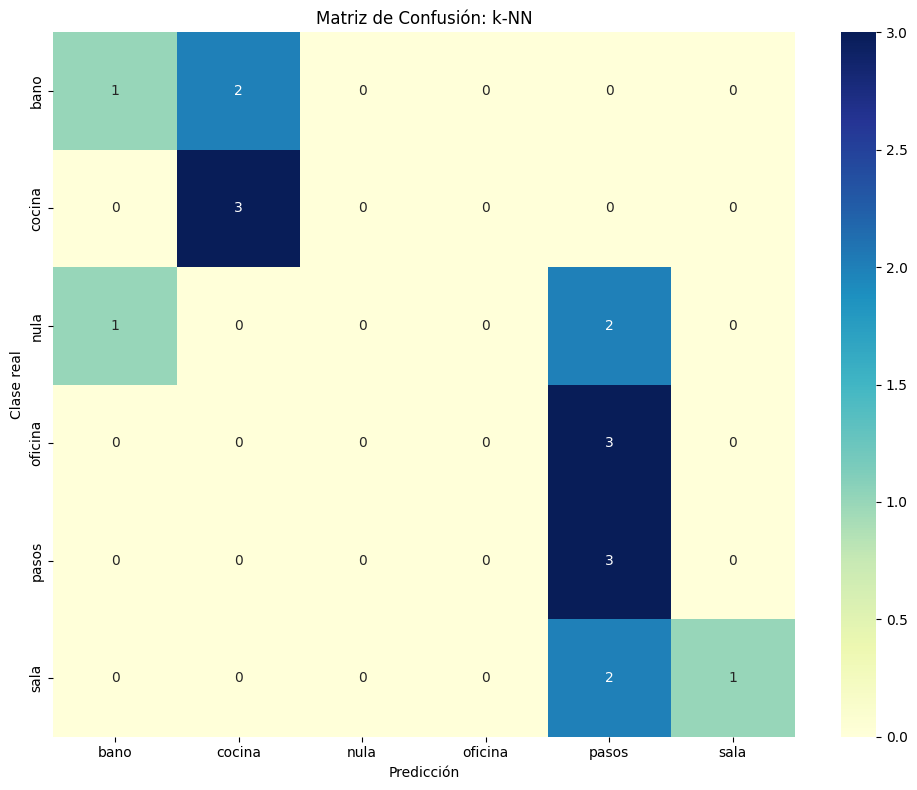

In [91]:
results = []
for i, (name, model) in enumerate(models.items()):
    print(f"\n{name}:")

    cv_scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1_macro').mean()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    test_f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    print(f"F1-Score (Validación cruzada): {cv_scores:.4f}")
    print(f"F1-Score: {test_f1:.4f}")
    print(f"Precisión: {accuracy:.4f}")

    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    results.append({'Modelo': name, 'F1-Score (Validación cruzada)': cv_scores, 'F1-Score': test_f1, 'Precisión': accuracy})

    print("\nResultados:")
    print(results)

    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu',xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Matriz de Confusión: {name}')
    plt.ylabel('Clase real')
    plt.xlabel('Predicción')
    plt.tight_layout()
    plt.show()

A pesar de que _Random Forest_ fue el modelo que dio el mejor resultado, todos tuvieron resultados deplorables incluso con la validación cruzada realizada. Una posible causa son algunos archivos del conjunto de entrenamiento con varios sonidos de fondo que dificultaron la extracción de características; además, algunos archivos del conjunto de prueba fueron etiquetados incorrectamente.